# Time Series Analysis and Forecasting with CNNs

Convolutional Neural Network models, or CNNs for short, can be applied to time series forecasting. I will be presenting different type of scenarios that we usually come across during solving problems related with time series and the variety of CNN architectures that we can use to tackle them.

Variety of time series related problems:
- CNN Models for Univariate time series
- CNN Models for Multivariate time series
- CNN Models for Multistep time series
- CNN Models for Multivariate and Multisteps time series


## Univariate CNN Models

Although traditionally developed for two-dimensional image data, CNNs can be used to model univariate time series forecasting problems. Univariate time series are datasets comprised of a single series of observations with a temporal ordering and a model is required to learn from the series of past observations to predict the next value in the sequence.

This section is divided into two parts:
1. Data Preparation 
2. CNN Model


### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv("data/Alcohol_Sales.csv", parse_dates=["DATE"], index_col="DATE")

In [9]:
df.head(2)

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458


In [15]:
df.rename({"S4248SM144NCEN":"Sales"}, axis = 1,inplace=True)

In [16]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [17]:
df.tail()

,Sales
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


In [19]:
df.count()

Sales    325
dtype: int64

So here the goal is to moniter Sales data over time. We have to model the Sales series 

In [22]:
df["Sales"].values

array([ 3459,  3458,  4002,  4564,  4221,  4529,  4466,  4137,  4126,
        4259,  4240,  4936,  3031,  3261,  4160,  4377,  4307,  4696,
        4458,  4457,  4364,  4236,  4500,  4974,  3075,  3377,  4443,
        4261,  4460,  4985,  4324,  4719,  4374,  4248,  4784,  4971,
        3370,  3484,  4269,  3994,  4715,  4974,  4223,  5000,  4235,
        4554,  4851,  4826,  3699,  3983,  4262,  4619,  5219,  4836,
        4941,  5062,  4365,  5012,  4850,  5097,  3758,  3825,  4454,
        4635,  5210,  5057,  5231,  5034,  4970,  5342,  4831,  5965,
        3796,  4019,  4898,  5090,  5237,  5447,  5435,  5107,  5515,
        5583,  5346,  6286,  4032,  4435,  5479,  5483,  5587,  6176,
        5621,  5889,  5828,  5849,  6180,  6771,  4243,  4952,  6008,
        5353,  6435,  6673,  5636,  6630,  5887,  6322,  6520,  6678,
        5082,  5216,  5893,  5894,  6799,  6667,  6374,  6840,  5575,
        6545,  6789,  7180,  5117,  5442,  6337,  6525,  7216,  6761,
        6958,  7070,

Okay so basically we need to model the above series and we need to transform a univariate series into a supervised learning problem.

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import array
import torch.optim as optim

In [113]:
#function for data transformation

def split_sequence(sequences, n_steps):

    X, y = [], []
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences)-1:
            break 
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)

Running the example splits the univariate series into X and y where each row in X is of shape `n_steps` and y is single output per X's rows.

In [114]:
#create feature and target from the above function

sequences = df.Sales.values.tolist()


X, y = split_sequence(sequences, 3)

In [115]:
X[:2], y[:2]

(tensor([[3459., 3458., 4002.],
         [3458., 4002., 4564.]]),
 tensor([4564., 4221.]))

Now that we know how to prepare a univariate series for modeling, let’s look at developing a CNN model that can learn the mapping of inputs to outputs.

### CNN Model

A one-dimensional CNN is a CNN model that has a convolutional hidden layer that operates over a 1D sequence. This is followed by perhaps a second convolutional layer in some cases, such as very long input sequences, and then a pooling layer whose job it is to distill the output of the convolutional layer to the most salient elements. 

In [121]:
n_features = 1
X = X.view(X.shape[0], n_features, X.shape[1])


In [122]:
X.shape

torch.Size([322, 1, 3])

The CNN does not actually view the data as having time steps, instead, it is treated as a sequence over which convolutional read operations can be performed, like a one-dimensional image

Model Architecture:

- A convolutional layer with 64 filter maps and a kernel size of 2. 
- Max pooling layer and a dense layer to interpret the input feature 
- An output layer is specified that predicts a single numerical value
- Optimiser - Adam
- Loss function - MSE

In [162]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNNTimeSeriesModel(nn.Module):
    def __init__(self, n_steps, n_features):
        super(CNNTimeSeriesModel, self).__init__()

        self.cnn_layer = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.cnn_layer(x)
        x = self.fc_layers(x)
        return x

cnn_model = CNNTimeSeriesModel(3, 1)

epochs = 1000
optimizer = optim.Adam(cnn_model.parameters())
criterion = nn.MSELoss()

losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = cnn_model(X)

    # Reshape y and y_pred for calculating the loss
    y = y.view(y.shape[0], 1)
    y_pred = y_pred.view(y_pred.shape[0], 1)

    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/1000], Loss: 74998720.0000
Epoch [2/1000], Loss: 69209840.0000
Epoch [3/1000], Loss: 63561720.0000
Epoch [4/1000], Loss: 58039952.0000
Epoch [5/1000], Loss: 52810256.0000
Epoch [6/1000], Loss: 47840916.0000
Epoch [7/1000], Loss: 43138640.0000
Epoch [8/1000], Loss: 38794964.0000
Epoch [9/1000], Loss: 35010808.0000
Epoch [10/1000], Loss: 31438136.0000
Epoch [11/1000], Loss: 28039416.0000
Epoch [12/1000], Loss: 24832118.0000
Epoch [13/1000], Loss: 21810110.0000
Epoch [14/1000], Loss: 19041562.0000
Epoch [15/1000], Loss: 16477194.0000
Epoch [16/1000], Loss: 14101482.0000
Epoch [17/1000], Loss: 11918043.0000
Epoch [18/1000], Loss: 9936548.0000
Epoch [19/1000], Loss: 8165216.0000
Epoch [20/1000], Loss: 6609757.0000
Epoch [21/1000], Loss: 5270519.5000
Epoch [22/1000], Loss: 4147356.5000
Epoch [23/1000], Loss: 3238289.7500
Epoch [24/1000], Loss: 2537519.7500
Epoch [25/1000], Loss: 2034810.3750
Epoch [26/1000], Loss: 1715116.3750
Epoch [27/1000], Loss: 1558439.1250
Epoch [28/1000], Los

In [163]:
losses

[74998720.0,
 69209840.0,
 63561720.0,
 58039952.0,
 52810256.0,
 47840916.0,
 43138640.0,
 38794964.0,
 35010808.0,
 31438136.0,
 28039416.0,
 24832118.0,
 21810110.0,
 19041562.0,
 16477194.0,
 14101482.0,
 11918043.0,
 9936548.0,
 8165216.0,
 6609757.0,
 5270519.5,
 4147356.5,
 3238289.75,
 2537519.75,
 2034810.375,
 1715116.375,
 1558439.125,
 1540286.875,
 1632329.75,
 1803701.875,
 2022722.125,
 2258939.25,
 2485191.0,
 2679384.75,
 2825688.0,
 2914989.75,
 2944637.5,
 2917576.25,
 2841092.25,
 2725401.5,
 2582221.5,
 2423533.25,
 2260507.0,
 2102800.75,
 1958105.25,
 1831929.0,
 1727588.625,
 1646406.375,
 1588000.625,
 1550587.875,
 1531422.75,
 1527158.375,
 1534178.125,
 1548889.625,
 1567926.0,
 1588340.875,
 1607713.0,
 1624205.375,
 1636553.625,
 1644055.0,
 1646516.75,
 1644166.375,
 1637559.5,
 1627492.375,
 1614904.625,
 1600792.375,
 1586127.75,
 1571794.125,
 1558533.75,
 1546918.125,
 1537324.625,
 1529940.0,
 1524769.875,
 1521664.25,
 1520350.625,
 1520472.0,
 1521

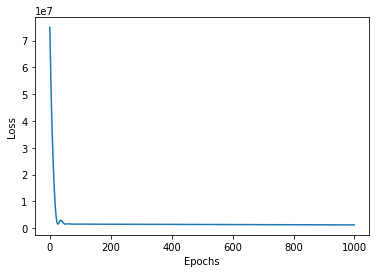

In [164]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

In [142]:
optimizer = optim.Adam(cnn_model.parameters())

criterion = nn.MSELoss()

In [149]:
y_pred = cnn_model.forward(X)
y_pred.shape
y_transform = y.view(y.shape[0])
y_pred_transform = y_pred.view(y.shape[0])
criterion(y_pred, y_pred_transform)

tensor(517380.9375, grad_fn=<MseLossBackward0>)

In [152]:
epochs = 10

for _ in range(epochs):
    
    optimizer.zero_grad()
    y_pred = cnn_model.forward(X)
    y_transform = y.view(y.shape[0])
    y_pred_transform = y_pred.view(y.shape[0])
    loss = criterion(y_pred_transform, y_transform)
    loss.backward()
    optimizer.step()
    print(loss.item())

72953696.0
72953696.0
72953696.0
72953696.0
72953696.0
72953696.0
72953696.0
72953696.0
72953696.0
72953696.0


In [116]:
cnn_layer = nn.Conv1d(in_channels= 1, out_channels= 64, kernel_size=2).float()

In [117]:
cnn_layer.weight.shape

torch.Size([64, 1, 2])

In [125]:
X.dtype

torch.float32

In [124]:
cnn_layer(X).shape

torch.Size([322, 64, 2])

In [130]:
mp_layer = nn.MaxPool1d(kernel_size=2)
mp_layer(cnn_layer(X))
nn.Flatten()(mp_layer(cnn_layer(X)))

tensor([[  2059.2356,  -3660.4692,    608.5523,  ...,    762.4320,
           1895.0309,   3037.9966],
        [  2342.9067,  -4001.3079,    689.2654,  ...,    870.0726,
           2157.5793,   3482.3110],
        [  2342.9067,  -4588.3999,    689.2654,  ...,    870.0726,
           2157.5793,   3482.5635],
        ...,
        [  7124.0020, -13922.8262,   2086.0293,  ...,   2654.8137,
           6566.0410,  10675.0508],
        [  7136.3130, -14072.8047,   2086.0293,  ...,   2716.3335,
           6609.5039,  11265.0684],
        [  7904.1211, -14890.3516,   2294.7524,  ...,   2961.5601,
           7294.1216,  12004.6367]], grad_fn=<ReshapeAliasBackward0>)

In [82]:
cnn_layer(torch.tensor([[12, 23]]))

RuntimeError: expected scalar type Long but found Float

In [59]:
m = nn.Conv1d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)

In [61]:
output.shape

torch.Size([20, 33, 24])

## Multivariate CNN Models

Multivariate time series data means data where there is more than one observation for each time step. 

There are two main models that we may require with multivariate time series data; they are:

1. Multiple Input Series. 
2. Multiple Parallel Series.